# EDA

## Libraries

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
from scipy.spatial import cKDTree

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import TargetEncoder

from scipy.stats import ttest_ind, chi2_contingency, normaltest

from scipy.stats import fisher_exact

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.linear_model import SGDClassifier
import pickle

## Reading Data

In [3]:
combined_flights_2022 = pd.read_parquet("../data/extracted/extracted_flight/extracted_flight_2022.parquet")
combined_flights_2021 = pd.read_parquet("../data/extracted/extracted_flight/extracted_flight_2021.parquet")
combined_flights_2020 = pd.read_parquet("../data/extracted/extracted_flight/extracted_flight_2020.parquet")
combined_flights_2019 = pd.read_parquet("../data/extracted/extracted_flight/extracted_flight_2019.parquet")

## Descriptive Statistics for all years

In [11]:
pattern_2019 = combined_flights_2019[["FlightDate","Airline", "Month", "DayOfWeek"]]
pattern_2020 = combined_flights_2020[["FlightDate","Airline", "Month", "DayOfWeek"]]
pattern_2021 = combined_flights_2021[["FlightDate","Airline", "Month", "DayOfWeek"]]
pattern_2022 = combined_flights_2022[["FlightDate","Airline", "Month", "DayOfWeek"]]

In [12]:
combined_pattern = pd.concat([pattern_2019, pattern_2020, pattern_2021, pattern_2022])

In [13]:
counts_by_month = combined_pattern.groupby('Month').count()

In [14]:
counts_by_month = counts_by_month.reset_index()

counts_by_month.rename(columns={'index': 'Month'}, inplace=True)

Text(0.5, 1.0, 'Number of flights per Month from 2019-2022')

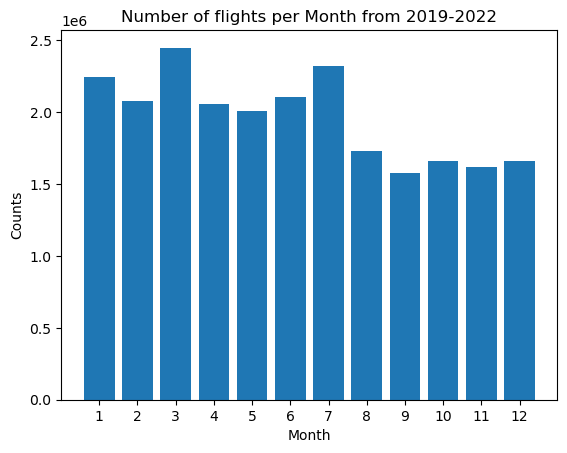

In [16]:
plt.bar(counts_by_month["Month"], counts_by_month["FlightDate"])
plt.xticks(ticks=counts_by_month["Month"], labels=counts_by_month["Month"])
plt.xlabel("Month")
plt.ylabel("Counts")
plt.title("Number of flights per Month from 2019-2022")

In [17]:
counts_by_week = combined_pattern.groupby('DayOfWeek').count()
counts_by_week = counts_by_week.reset_index()

Text(0.5, 1.0, 'Number of flights per Day of the Week from 2019-2022')

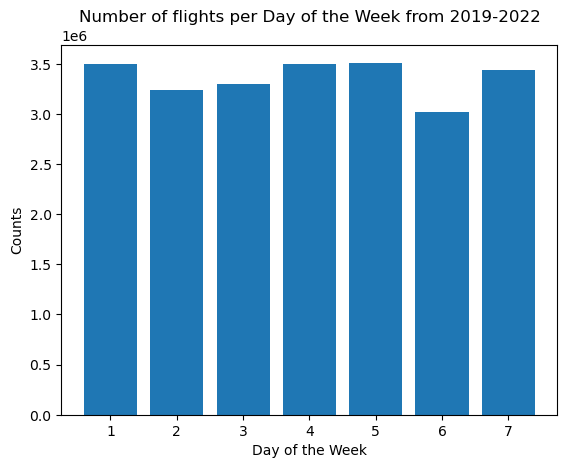

In [19]:
plt.bar(counts_by_week["DayOfWeek"], counts_by_week["FlightDate"])
plt.xlabel("Day of the Week")
plt.ylabel("Counts")
plt.title("Number of flights per Day of the Week from 2019-2022")


In [21]:
combined_flights_2019['total delay'] = combined_flights_2019['DepDelayMinutes']+ combined_flights_2019['ArrDelayMinutes']
combined_flights_2020['total delay'] = combined_flights_2020['DepDelayMinutes']+ combined_flights_2020['ArrDelayMinutes']
combined_flights_2021['total delay'] = combined_flights_2021['DepDelayMinutes']+ combined_flights_2021['ArrDelayMinutes']
combined_flights_2022['total delay'] = combined_flights_2022['DepDelayMinutes']+ combined_flights_2022['ArrDelayMinutes']

In [22]:
delay_config_2019 = combined_flights_2019[["FlightDate","Airline","total delay"]]
delay_config_2020 = combined_flights_2020[["FlightDate","Airline","total delay"]]
delay_config_2021 = combined_flights_2021[["FlightDate","Airline","total delay"]]
delay_config_2022 = combined_flights_2022[["FlightDate","Airline","total delay"]]

In [24]:
combined_delay = pd.concat([ delay_config_2019, delay_config_2020, delay_config_2021, delay_config_2022])

In [25]:
airline_counts = combined_delay.groupby('Airline').count()
airline_counts = airline_counts.reset_index()

Text(0.5, 1.0, 'Number of flights per Airline from 2019-2022')

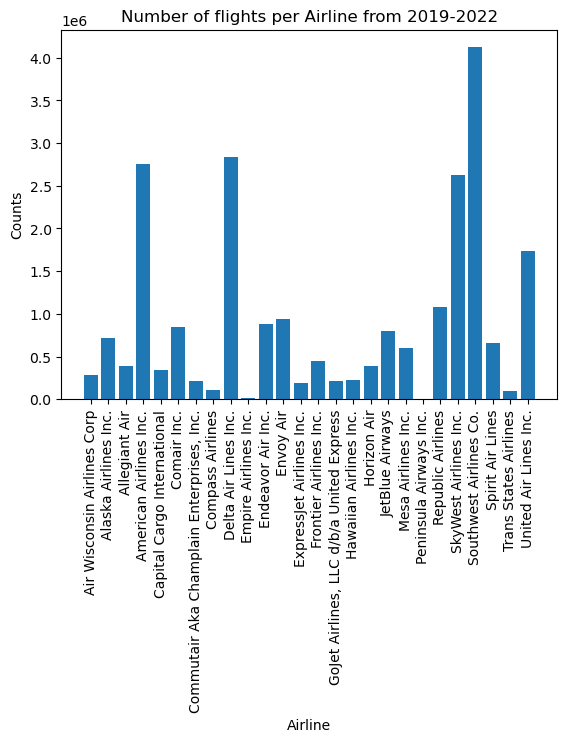

In [26]:
plt.bar(airline_counts["Airline"], airline_counts["FlightDate"])
plt.xlabel("Airline")
plt.xticks(rotation = 90)
plt.ylabel("Counts")
plt.title("Number of flights per Airline from 2019-2022")

In [27]:
combined_delay["count"] = combined_delay["Airline"].map(combined_delay["Airline"].value_counts())
combined_delay["normalized_count"] = (combined_delay["count"] - combined_delay["count"].min()) / (combined_delay["count"].max() - combined_delay["count"].min())
combined_delay

,FlightDate,Airline,total delay,count,normalized_count
0,2019-04-01,Envoy Air,0.0,945028,0.229001
1,2019-04-02,Envoy Air,0.0,945028,0.229001
2,2019-04-03,Envoy Air,0.0,945028,0.229001
3,2019-04-04,Envoy Air,279.0,945028,0.229001
4,2019-04-05,Envoy Air,9.0,945028,0.229001
...,...,...,...,...,...
590537,2022-03-31,Republic Airlines,NaN,1080175,0.261801
590538,2022-03-17,Republic Airlines,NaN,1080175,0.261801
590539,2022-03-08,Republic Airlines,759.0,1080175,0.261801
590540,2022-03-25,Republic Airlines,NaN,1080175,0.261801


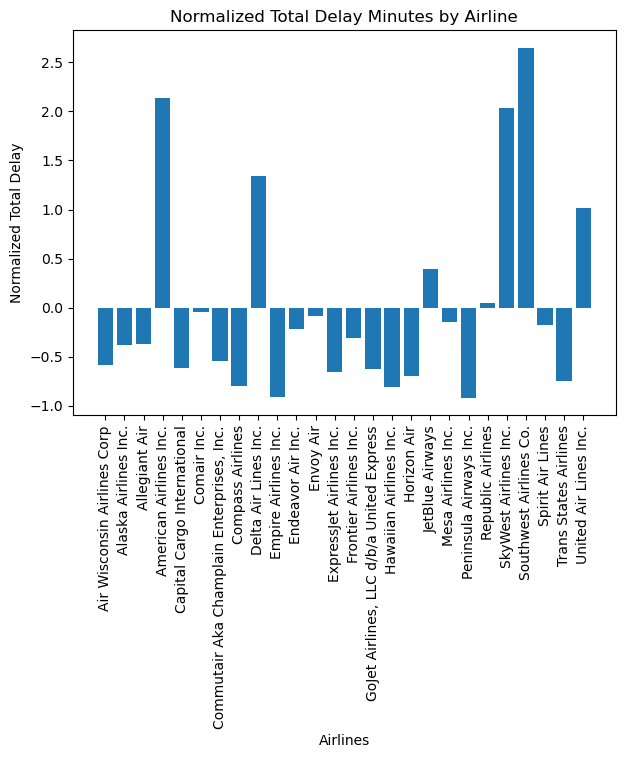

In [28]:
airline_delays = combined_delay.groupby("Airline").sum(numeric_only=True)[["total delay", "normalized_count"]].reset_index()

airline_delays["normalized_total_delay"] = (airline_delays["total delay"] - airline_delays["total delay"].mean()) / \
                                           airline_delays["total delay"].std()
plt.figure(figsize=(7, 5))
plt.bar(airline_delays["Airline"], airline_delays["normalized_total_delay"])


plt.xlabel("Airlines")
plt.ylabel("Normalized Total Delay")
plt.xticks(rotation =90)
plt.title("Normalized Total Delay Minutes by Airline")

plt.show()

In [34]:
# add flight delays bar plots

flightdelay_2019 = combined_flights_2019[(combined_flights_2019["DepDelay"] > 0) | (combined_flights_2019["ArrDelay"] > 0)
][["FlightDate", "Airline","Month", "DayOfWeek", "DepDelay", "ArrDelay"]]
flightdelay_2020 = combined_flights_2020[(combined_flights_2020["DepDelay"] > 0) | (combined_flights_2020["ArrDelay"] > 0)
][["FlightDate", "Airline","Month", "DayOfWeek", "DepDelay", "ArrDelay"]]
flightdelay_2021 = combined_flights_2021[(combined_flights_2021["DepDelay"] > 0) | (combined_flights_2021["ArrDelay"] > 0)
][["FlightDate", "Airline","Month", "DayOfWeek", "DepDelay", "ArrDelay"]]
flightdelay_2022 = combined_flights_2022[(combined_flights_2022["DepDelay"] > 0) | (combined_flights_2022["ArrDelay"] > 0)
][["FlightDate", "Airline","Month", "DayOfWeek", "DepDelay", "ArrDelay"]]


In [35]:
combined_delays = pd.concat([flightdelay_2019, flightdelay_2020, flightdelay_2021, flightdelay_2022])

In [36]:
delays_by_month = combined_delays.groupby('Month').count()
delays_by_month = delays_by_month.reset_index()

Text(0.5, 1.0, 'Number of flight delays per Month from 2019-2022')

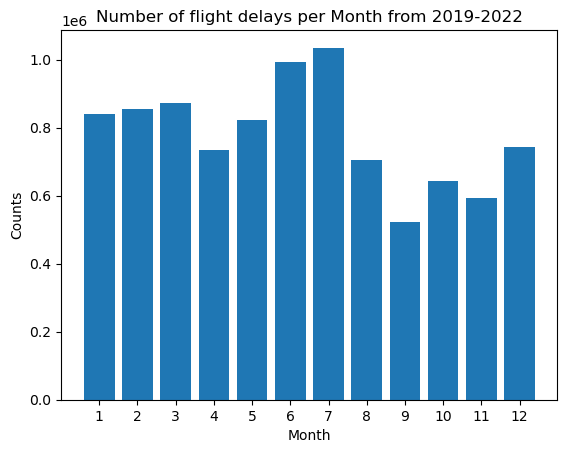

In [37]:
plt.bar(delays_by_month["Month"], delays_by_month["FlightDate"])
plt.xticks(ticks=delays_by_month["Month"], labels=delays_by_month["Month"])
plt.xlabel("Month")
plt.ylabel("Counts")
plt.title("Number of flight delays per Month from 2019-2022")

In [38]:
delays_by_week = combined_delays.groupby('DayOfWeek').count()
delays_by_week = delays_by_week.reset_index()

Text(0.5, 1.0, 'Number of flight delays per Day of Week from 2019-2022')

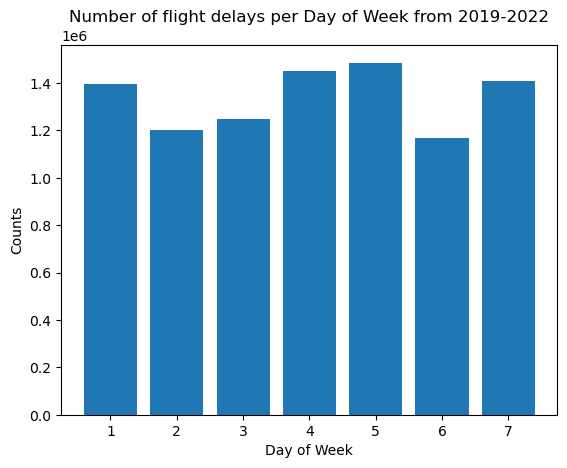

In [39]:
plt.bar(delays_by_week["DayOfWeek"], delays_by_week["FlightDate"])
plt.xticks(ticks=delays_by_week["DayOfWeek"], labels=delays_by_week["DayOfWeek"])
plt.xlabel("Day of Week")
plt.ylabel("Counts")
plt.title("Number of flight delays per Day of Week from 2019-2022")

## Inferential Statistics for all years

In [30]:
#Fisher's Exact Test 

#get flightdate, cancelled, diverted 
binary_2019 = combined_flights_2019[["FlightDate","Cancelled", "Diverted"]]
binary_2020 = combined_flights_2020[["FlightDate","Cancelled", "Diverted"]]
binary_2021 = combined_flights_2021[["FlightDate","Cancelled", "Diverted"]]
binary_2022 = combined_flights_2022[["FlightDate","Cancelled", "Diverted"]]
#concat 
binary_all = pd.concat([binary_2019, binary_2020, binary_2021, binary_2022])
#make contingency table 
contingency_table = pd.crosstab(binary_all['Cancelled'], binary_all['Diverted'])
#set hypothesis
#H0 = cancelled and diverted are not independent 
#Ha cancelled and diverted are indepeneent 
#perform test
odds_ratio, p_value = fisher_exact(contingency_table, alternative='two-sided')

print(f"Odds Ratio: {odds_ratio}")
print(f"P-value: {p_value}")


Odds Ratio: 0.0
P-value: 0.0


In [31]:
contingency_table

Diverted,False,True
Cancelled,,
False,22760982,54394
True,688894,0


since pvalue is less than 0.05, there is evidence to conclude that there is significant association between cancelled and diverted 

## EDA for 2019

## Data Cleaning

In [8]:
flight_data = combined_flights_2019
print(combined_flights_2019.head())

  FlightDate    Airline Origin Dest  Cancelled  Diverted  CRSDepTime  DepTime  \
0 2019-04-01  Envoy Air    LIT  ORD      False     False        1212   1209.0   
1 2019-04-02  Envoy Air    LIT  ORD      False     False        1212   1200.0   
2 2019-04-03  Envoy Air    LIT  ORD      False     False        1212   1203.0   
3 2019-04-04  Envoy Air    LIT  ORD      False     False        1212   1435.0   
4 2019-04-05  Envoy Air    LIT  ORD      False     False        1212   1216.0   

   DepDelayMinutes  DepDelay  ...  WheelsOff  WheelsOn  TaxiIn  CRSArrTime  \
0              0.0      -3.0  ...     1219.0    1342.0     8.0        1405   
1              0.0     -12.0  ...     1210.0    1339.0     9.0        1405   
2              0.0      -9.0  ...     1214.0    1336.0     6.0        1405   
3            143.0     143.0  ...     1452.0    1615.0     6.0        1405   
4              4.0       4.0  ...     1234.0    1357.0    13.0        1405   

   ArrDelay  ArrDel15  ArrivalDelayGroups  A

In [9]:
# Identify Missing Values
missing_values = flight_data.isnull().sum()
print("Missing Values Count:\n", missing_values)

Missing Values Count:
 FlightDate                 0
Airline                    0
Origin                     0
Dest                       0
Cancelled                  0
                       ...  
ArrDel15              174420
ArrivalDelayGroups    174420
ArrTimeBlk                 0
DistanceGroup              0
DivAirportLandings         0
Length: 61, dtype: int64


In [40]:
# Fill Missing Values Properly
for col in flight_data.columns:
    if flight_data[col].dtype == "object":  # Categorical Columns
        flight_data.loc[:, col] = flight_data[col].fillna(flight_data[col].mode()[0])
    else:  # Numerical Columns
        flight_data.loc[:, col] = flight_data[col].fillna(flight_data[col].median())

In [41]:
# Detect and Handle Outliers
def cap_outliers(df, column):
    """
    Cap outliers using the 99th percentile method.
    """
    upper_limit = np.percentile(df[column], 99)
    lower_limit = np.percentile(df[column], 1)
    df[column] = np.where(df[column] > upper_limit, upper_limit, df[column])
    df[column] = np.where(df[column] < lower_limit, lower_limit, df[column])

# Apply outlier capping to numerical columns only
numerical_cols = flight_data.select_dtypes(include=["int64", "float64"]).columns
for col in numerical_cols:
    cap_outliers(flight_data, col)

In [42]:
# Remove Duplicates
before_duplicates = flight_data.shape[0]
flight_data.drop_duplicates(inplace=True)
after_duplicates = flight_data.shape[0]

before_duplicates, after_duplicates

(8091684, 8091684)

In [43]:
print(flight_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8091684 entries, 0 to 638648
Data columns (total 62 columns):
 #   Column                                   Dtype         
---  ------                                   -----         
 0   FlightDate                               datetime64[us]
 1   Airline                                  object        
 2   Origin                                   object        
 3   Dest                                     object        
 4   Cancelled                                bool          
 5   Diverted                                 bool          
 6   CRSDepTime                               float64       
 7   DepTime                                  float64       
 8   DepDelayMinutes                          float64       
 9   DepDelay                                 float64       
 10  ArrTime                                  float64       
 11  ArrDelayMinutes                          float64       
 12  AirTime                           

In [44]:
print(flight_data.describe())

                       FlightDate    CRSDepTime       DepTime  \
count                     8091684  8.091684e+06  8.091684e+06   
mean   2019-07-03 10:14:37.572974  1.331190e+03  1.337320e+03   
min           2019-01-01 00:00:00  5.200000e+02  5.020000e+02   
25%           2019-04-05 00:00:00  9.150000e+02  9.220000e+02   
50%           2019-07-04 00:00:00  1.322000e+03  1.327000e+03   
75%           2019-10-01 00:00:00  1.735000e+03  1.741000e+03   
max           2019-12-31 00:00:00  2.246000e+03  2.302000e+03   
std                           NaN  4.861953e+02  4.935457e+02   

       DepDelayMinutes      DepDelay       ArrTime  ArrDelayMinutes  \
count     8.091684e+06  8.091684e+06  8.091684e+06     8.091684e+06   
mean      1.253157e+01  9.300230e+00  1.463374e+03     1.262411e+01   
min       0.000000e+00 -1.400000e+01  2.300000e+01     0.000000e+00   
25%       0.000000e+00 -6.000000e+00  1.052000e+03     0.000000e+00   
50%       0.000000e+00 -2.000000e+00  1.502000e+03     0.00

## Data Formatting

In [45]:
# Convert Columns to Appropriate Data Types
# Convert numerical columns stored as strings to integers or floats
for col in flight_data.columns:
    if flight_data[col].dtype == "object":  # Check if column is string-based
        try:
            flight_data[col] = pd.to_numeric(flight_data[col])  # Convert to numeric
        except ValueError:
            pass  # Skip if conversion is not possible (e.g., non-numeric text columns)

In [46]:
# Standardize Date Formatting
date_columns = ["FlightDate"]  # Update with actual date column names in your dataset

for col in date_columns:
    flight_data[col] = pd.to_datetime(flight_data[col], errors="coerce")  # Convert to datetime format

In [47]:
print(flight_data.dtypes)

FlightDate            datetime64[us]
Airline                       object
Origin                        object
Dest                          object
Cancelled                       bool
                           ...      
ArrivalDelayGroups           float64
ArrTimeBlk                    object
DistanceGroup                float64
DivAirportLandings           float64
total delay                  float64
Length: 62, dtype: object


## Data Aggregation 

In [48]:
# Summarization - Creating Summary Statistics
summary_statistics = flight_data.describe()

# Grouping - Organizing Data into Groups Based on Airline and Month
grouped_data = flight_data.groupby(["Marketing_Airline_Network", "Month"]).agg({
    "DepDelayMinutes": ["mean", "median", "sum"],
    "ArrDelayMinutes": ["mean", "median", "sum"],
    "Distance": ["mean", "sum"]
}).reset_index()

grouped_data.head()

Marketing_Airline_Network Month DepDelayMinutes                    \
                                             mean median        sum   
0                        AA   1.0       10.471069    0.0  1767129.0   
1                        AA   2.0       12.790992    0.0  1990419.0   
2                        AA   3.0       10.554995    0.0  1865057.0   
3                        AA   4.0       12.253568    0.0  2098926.0   
4                        AA   5.0       14.699663    0.0  2689612.0   

  ArrDelayMinutes                      Distance               
             mean median        sum        mean          sum  
0       11.519616    0.0  1944085.0  687.631471  116046750.0  
1       14.105365    0.0  2194950.0  687.894635  107043972.0  
2       10.982665    0.0  1940626.0  691.705250  122223626.0  
3       12.770700    0.0  2187506.0  680.400050  116546405.0  
4       15.492280    0.0  2834638.0  686.307590  125574386.0

## Data Discretization

In [49]:
# Binning Departure Delay into Categories: On-time, Moderate Delay, Severe Delay
flight_data["DepDelayCategory"] = pd.cut(
    flight_data["DepDelayMinutes"],
    bins=[-10, 0, 15, 300],  # Define custom bins
    labels=["On-time", "Moderate Delay", "Severe Delay"]
)

# Binning Distance into Short, Medium, and Long Flights
flight_data["DistanceCategory"] = pd.cut(
    flight_data["Distance"],
    bins=[0, 500, 1500, 3000],
    labels=["Short", "Medium", "Long"]
)

## Data Enrichment

In [50]:
# Creating Time of Day Feature from Scheduled Departure Time
def get_time_of_day(dep_time):
    if dep_time < 600:
        return "Early Morning"
    elif dep_time < 1200:
        return "Morning"
    elif dep_time < 1800:
        return "Afternoon"
    else:
        return "Evening"

flight_data["TimeOfDay"] = flight_data["CRSDepTime"].apply(get_time_of_day)

## Descriptive Statistics for 2019

In [51]:
print(flight_data.describe())

                       FlightDate    CRSDepTime       DepTime  \
count                     8091684  8.091684e+06  8.091684e+06   
mean   2019-07-03 10:14:37.572974  1.331190e+03  1.337320e+03   
min           2019-01-01 00:00:00  5.200000e+02  5.020000e+02   
25%           2019-04-05 00:00:00  9.150000e+02  9.220000e+02   
50%           2019-07-04 00:00:00  1.322000e+03  1.327000e+03   
75%           2019-10-01 00:00:00  1.735000e+03  1.741000e+03   
max           2019-12-31 00:00:00  2.246000e+03  2.302000e+03   
std                           NaN  4.861953e+02  4.935457e+02   

       DepDelayMinutes      DepDelay       ArrTime  ArrDelayMinutes  \
count     8.091684e+06  8.091684e+06  8.091684e+06     8.091684e+06   
mean      1.253157e+01  9.300230e+00  1.463374e+03     1.262411e+01   
min       0.000000e+00 -1.400000e+01  2.300000e+01     0.000000e+00   
25%       0.000000e+00 -6.000000e+00  1.052000e+03     0.000000e+00   
50%       0.000000e+00 -2.000000e+00  1.502000e+03     0.00

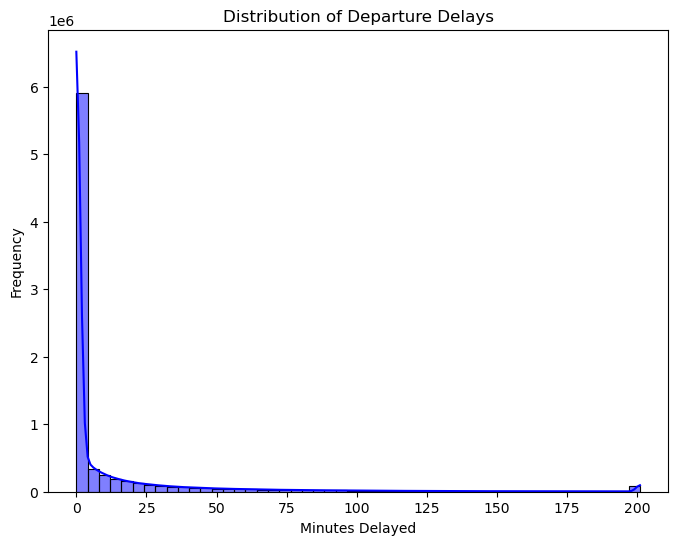

In [52]:
# Distribution of Departure Delays
plt.figure(figsize=(8, 6))
sns.histplot(flight_data["DepDelayMinutes"], bins=50, kde=True, color="blue")
plt.title("Distribution of Departure Delays")
plt.xlabel("Minutes Delayed")
plt.ylabel("Frequency")
plt.show()

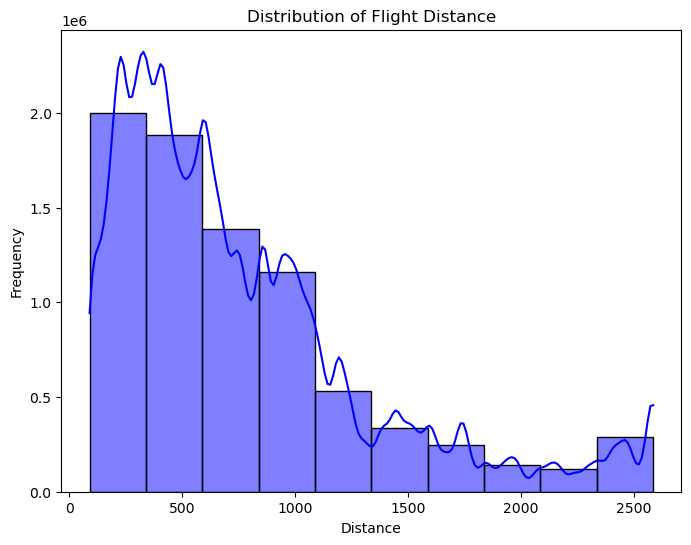

In [53]:
# Distribution of Flight Distance
plt.figure(figsize=(8, 6))
sns.histplot(flight_data["Distance"], bins=10, kde=True, color="blue")
plt.title("Distribution of Flight Distance")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

## Bivariate Analysis

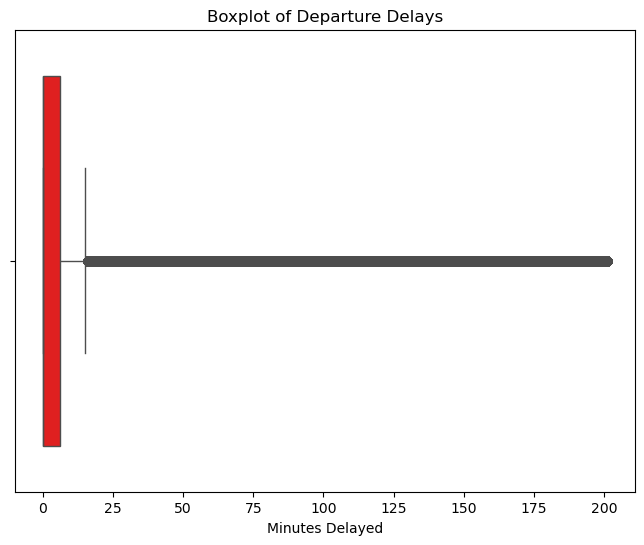

In [54]:
# Boxplot for Outlier Detection
plt.figure(figsize=(8, 6))
sns.boxplot(x=flight_data["DepDelayMinutes"], color="red")
plt.title("Boxplot of Departure Delays")
plt.xlabel("Minutes Delayed")
plt.show()

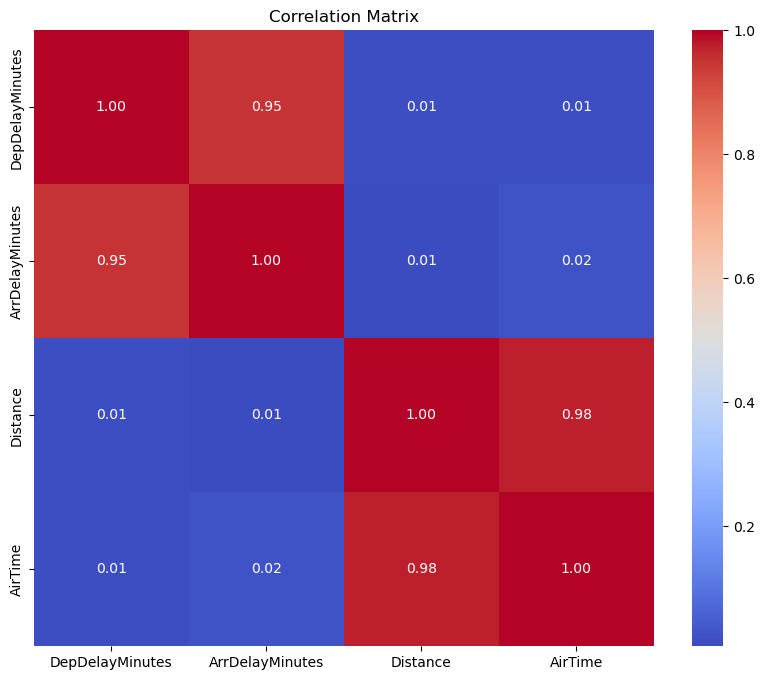

In [55]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(flight_data[["DepDelayMinutes", "ArrDelayMinutes", "Distance", "AirTime"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

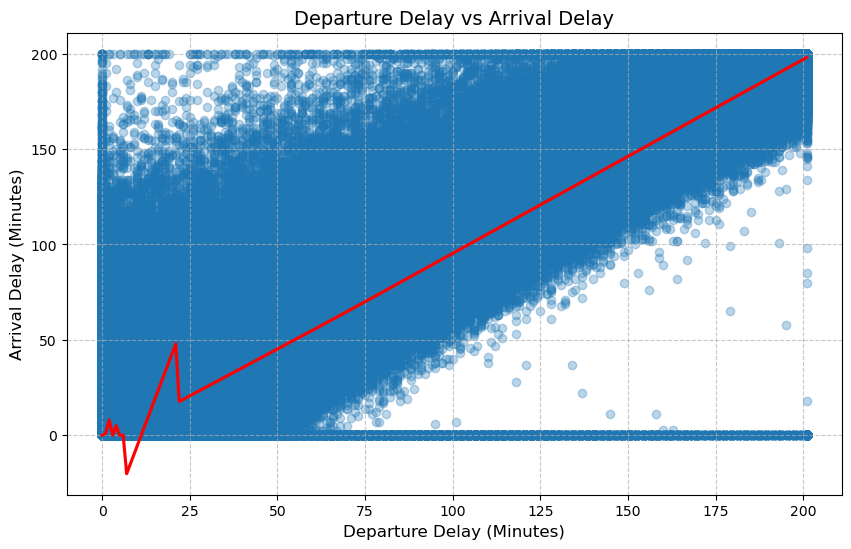

In [57]:
# Scatterplot with Trendline
plt.figure(figsize=(10, 6))

# Scatterplot with Transparency and Trendline
sns.regplot(
    x=flight_data["DepDelayMinutes"],
    y=flight_data["ArrDelayMinutes"],
    scatter_kws={"alpha": 0.3},  # Adjust transparency to reduce clutter
    line_kws={"color": "red"},  # Trendline color
    lowess=True  # Smooth trendline for better pattern visualization
)

plt.title("Departure Delay vs Arrival Delay", fontsize=14)
plt.xlabel("Departure Delay (Minutes)", fontsize=12)
plt.ylabel("Arrival Delay (Minutes)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

## Inferential Statistics

In [60]:
# Apply categorization
flight_data["TimeOfDay"] = flight_data["CRSDepTime"].apply(get_time_of_day)

# Step 3: Define two groups: Morning vs Evening flights
morning_delays = flight_data[flight_data["TimeOfDay"] == "Morning"]["DepDelayMinutes"]
evening_delays = flight_data[flight_data["TimeOfDay"] == "Evening"]["DepDelayMinutes"]

# Step 4: Perform the T-Test
t_stat, p_value = ttest_ind(morning_delays, evening_delays, equal_var=False)

# Step 5: Print the results
print(f"\n✅ T-Test: Morning vs Evening Delays")
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.5f}")

# Interpretation
if p_value < 0.05:
    print("Statistically significant difference in delays between morning and evening flights.")
else:
    print("No significant difference in delays between morning and evening flights.")


✅ T-Test: Morning vs Evening Delays
t-statistic: -288.515, p-value: 0.00000
Statistically significant difference in delays between morning and evening flights.


In [61]:
# Apply categorization
flight_data["TimeOfDay"] = flight_data["CRSDepTime"].apply(get_time_of_day)

# Define Severe Delay: 1 if delay is more than 60 minutes, otherwise 0
flight_data["SevereDelay"] = (flight_data["DepDelayMinutes"] > 60).astype(int)

# Step 3: Create a Contingency Table
contingency_table = pd.crosstab(flight_data["TimeOfDay"], flight_data["SevereDelay"])

# Step 4: Perform Chi-Square Test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Step 5: Print Results
print("\n✅ Chi-Square Test: Time of Day vs Severe Delays")
print(f"Chi-Square Statistic: {chi2_stat:.3f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-Value: {p_value:.5f}")

# Interpretation
if p_value < 0.05:
    print("Statistically significant relationship between time of day and severe delays.")
else:
    print("No significant relationship between time of day and severe delays.")

# Step 6: Display Contingency Table
print("\n✅ Contingency Table:\n", contingency_table)



✅ Chi-Square Test: Time of Day vs Severe Delays
Chi-Square Statistic: 67418.954
Degrees of Freedom: 3
P-Value: 0.00000
Statistically significant relationship between time of day and severe delays.

✅ Contingency Table:
 SevereDelay          0       1
TimeOfDay                     
Afternoon      2696253  225309
Early Morning   210506    7254
Evening        1638759  173959
Morning        3010586  129058


## Time Series Analysis

In [62]:
flight_data["FlightDate"] = pd.to_datetime(flight_data["FlightDate"], format="%Y%m%d")

daily_delays = flight_data.groupby("FlightDate")[["DepDelayMinutes", "ArrDelayMinutes"]].mean().reset_index()

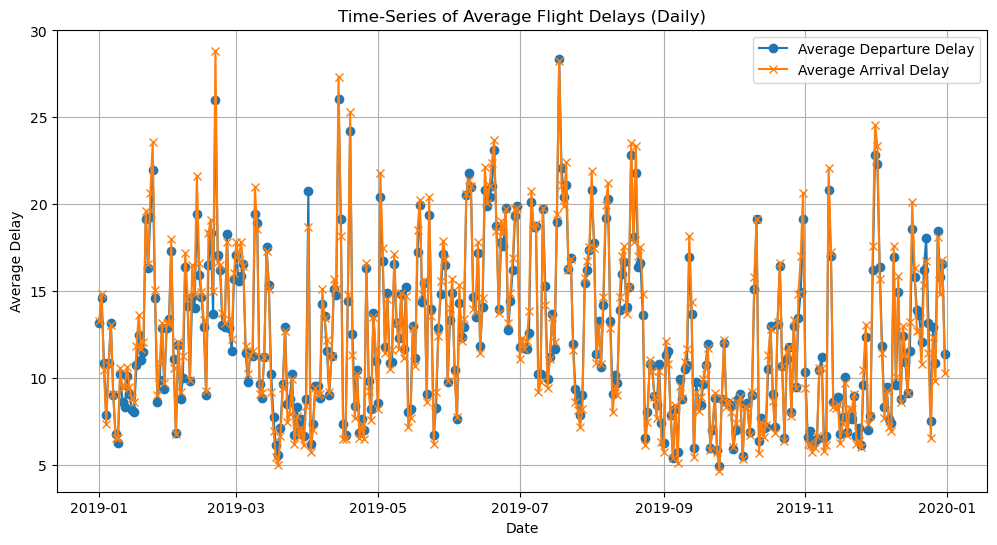

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(daily_delays["FlightDate"], daily_delays["DepDelayMinutes"], label="Average Departure Delay", marker="o")
plt.plot(daily_delays["FlightDate"], daily_delays["ArrDelayMinutes"], label="Average Arrival Delay", marker="x")
plt.title("Time-Series of Average Flight Delays (Daily)")
plt.xlabel("Date")
plt.ylabel("Average Delay")
plt.legend()
plt.grid(True)
plt.show()

## Matching airlines to weather stations
This step was completed once to generate the airport_station_key.csv, and as such was commented out

In [ ]:
# # Downloaded and obtained the location of each station
# df_station_latlon=pd.read_csv(r'ghcnd-stations.csv')
# weather_df = df_station_latlon[['ID', 'Latitude', 'Longitude']]

In [ ]:
# # Read combined parquet file and obtain a unique list of all origins and destinations
# raw = pd.read_parquet(r'combined_data.parquet')
# df_unique_origin = raw[['FlightDate', 'Origin']].drop_duplicates().rename(columns={'FlightDate': 'Date', 'Origin': 'Location'})
# df_unique_dest = raw[['FlightDate', 'Dest']].drop_duplicates().rename(columns={'FlightDate': 'Date', 'Dest': 'Location'})

In [ ]:
# # Combine the two DataFrames and drop the duplicates
# df_date_location = pd.concat([df_unique_origin, df_unique_dest]).drop_duplicates()
# airports = df_date_location[['Location']].drop_duplicates()

In [ ]:
# # Get locations of airports and pull out relevant features
# airport_locations = pd.read_csv(r'airports.dat', header=None)
# airport_latlon = airport_locations[[1,2,3,4,6,7]].rename(columns={1:'Airport Name', 2:'City', 3:'Country', 4: 'Location', 6: 'Latitude', 7: 'Longitude'})

In [ ]:
# # Merge the unique airport list found in the flight data set with the latitude and logitutde data found from the airport location data set
# airport_latlon_complete = pd.merge(airports, airport_latlon, on='Location', how='left').sort_values('Location').reset_index(drop=True)
# airport_df = airport_latlon_complete[['Location', 'Latitude', 'Longitude']]

In [ ]:
# # Use cKDTree to merge the 2 datasets together

# # Convert lat/lon to NumPy arrays
# airport_coords = np.radians(airport_df[['Latitude', 'Longitude']].values)
# weather_coords = np.radians(weather_df[['Latitude', 'Longitude']].values)

# # Create a KD-Tree for fast nearest neighbor search
# tree = cKDTree(weather_coords)

# # Find the nearest weather station for each airport
# distances, indices = tree.query(airport_coords, k=1)  # k=1 finds the closest station

# # Extract the matched stations
# nearest_stations = weather_df.iloc[indices].reset_index(drop=True)

# # Combine results
# airport_df["closest_station_name"] = nearest_stations["ID"]
# airport_df["station_lat"] = nearest_stations["Latitude"]
# airport_df["station_lon"] = nearest_stations["Longitude"]
# airport_df["distance_km"] = distances * 6371  # Convert radians to kilometers

# # Save and display results
# airport_df[['Airport', 'Closest_Station']].to_csv(r"airport_station_key.csv", index=False)